# Regression Analysis for Estimating Prices
**By [Czarina Luna](https://www.linkedin.com/in/czarinagluna/)**

### Contents
* [I. Overview](#I.-Overview)
* [II. Business Problem](#II.-Business-Problem)
* [III. Data Understanding](#III.-Data-Understanding)
    * [3.1 Exploratory Data Analysis](#3.1-Exploratory-Data-Analysis)
    * [3.2 Geospatial Mapping](#3.2-Geospatial-Mapping)
    * [3.3 Feature Engineering](#3.3-Feature-Engineering)
* [IV. Data Modeling](#IV.-Data-Modeling)
    * [4.1 Linear Regression](#4.1-Linear-Regression)
    * [4.2 Decision Tree](#4.2-Decision-Tree)
    * [4.3 Random Forest](#4.3-Random-Forest)
* [V. Results](#V.-Results)
* [VI. Further Research](#VI.-Further-Research)

## I. Overview

An analysis and regression modeling of over 21,000 real estate transactions in King County, Washington is completed to improve home valuation and real estate advisory. The findings include top features that are important to the *bestimate* model, which are square footage of living space, distance to Seattle, total distance to both Seattle and Redmond, distance to Redmond, and square footage of living space of the nearest 15 neighbors. The *bestimate* model that is the tuned random forest performs best in predicting house prices based on over 20 features. It explains 88% of the variance in the data and its predictions are USD 107,000 off from the actual prices on average.

## II. Business Problem

Real estate agencies in King County, Washington may be able to improve their advisory services by identifying important features that factor in home valuation based on relevant data. Doing so will allow real estate agents to provide more accurate prices to clients as supported by historical records. Using publicly available data, I describe patterns in real estate transactions such as features that likely drive prices. To take it a step further, I develop a prototype for a client-facing application that serves as a home value estimator, modeled from the data.

## III. Data Understanding

The [King County data](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction) spans a year between 2014 and 2015 with over 21,000 real estate transactions. Among the 21 variables featured, `price` is the dependent variable to predict. A full description of all column features is provided along with other data files, available in the repository's [data folder](https://github.com/czarinagluna/regression-analysis-for-estimating-prices/tree/main/Data).

To prepare the data for analysis, the pre-processing steps are taken below:
* Convert `date` to a date time format and create `month` feature
* Remove outliers for `price` and `bedrooms`
* Replace values for `waterfront`, `view`, `condition`, `grade` with a number scale for consistency
* Create `basement` feature using `sqft_basement` to determine basement or none
* Create `renovated` feature using `yr_renovated` to determine renovation or none
* Create `age` feature by subtracting the `yr_built` from year of `date` sold

In [1]:
import pandas as pd
import numpy as np

# Import the dataset
data = pd.read_csv('data/kc_house_data.csv')

In [2]:
pd.set_option('display.max_columns', 30)

# Quick look at the data structure
data.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


In [3]:
# Convert date to date time format
data['date'] = pd.to_datetime(data['date'])

In [4]:
data['month'] = pd.DatetimeIndex(data['date']).month

Summary statistics of numerical features:

In [5]:
data.drop(columns=['id', 'zipcode', 'lat', 'long']).describe().T.astype('int')

,count,mean,std,min,25%,50%,75%,max
price,21597,540296,367368,78000,322000,450000,645000,7700000
bedrooms,21597,3,0,1,3,3,4,33
bathrooms,21597,2,0,0,1,2,2,8
sqft_living,21597,2080,918,370,1430,1910,2550,13540
sqft_lot,21597,15099,41412,520,5040,7618,10685,1651359
floors,21597,1,0,1,1,1,2,3
sqft_above,21597,1788,827,370,1190,1560,2210,9410
yr_built,21597,1970,29,1900,1951,1975,1997,2015
yr_renovated,17755,83,399,0,0,0,0,2015
sqft_living15,21597,1986,685,399,1490,1840,2360,6210


**Data Cleaning**

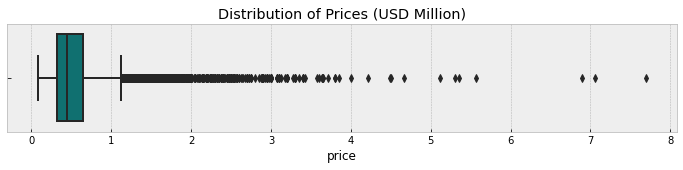

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create dataframe with price in millions
price_data = data[['price']]/1000000 

plt.figure(figsize=(12, 2))
plt.style.use('bmh')

sns.boxplot(x='price', data=price_data, color='teal')

plt.title('Distribution of Prices (USD Million)')

plt.savefig('data/images/fig0.png', dpi=200, transparent=True)
plt.show()

In [7]:
# Remove outliers in prices
data = data[(data.price < data.price.quantile(.995)) & 
            (data.price > data.price.quantile(.005))] 

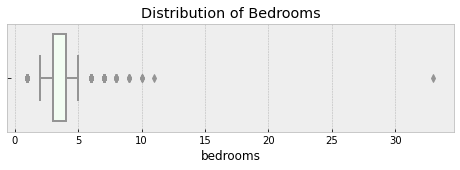

In [8]:
plt.figure(figsize=(8, 2))
sns.boxplot(x='bedrooms', data=data, color='honeydew')

plt.title('Distribution of Bedrooms') 

plt.savefig('data/images/fig1.png', dpi=200, transparent=True)
plt.show()

Likely a typographical error, the number of 33 bedrooms is corrected to 3.

In [9]:
data.loc[(data.bedrooms == 33), 'bedrooms'] = 3 

In [10]:
# Replace missing values with no waterfront
data.loc[data['waterfront'].isnull(), 'waterfront'] = 'NO'

data['waterfront'] = data['waterfront'].apply(lambda x: 0 if x == 'NO' else 1) 

In [11]:
# Replace missing values with no view
data.loc[data.view.isnull(), 'view'] = 'NONE'

data['view'] = data['view'].replace({'NONE':0,
                                     'FAIR':1, 
                                     'AVERAGE':2, 
                                     'GOOD':3, 
                                     'EXCELLENT':4}) 

In [12]:
data['condition'] = data['condition'].replace({'Poor':0, 
                                               'Fair':1, 
                                               'Average':2, 
                                               'Good':3, 
                                               'Very Good':4})

In [13]:
data['grade'] = data['grade'].map(lambda x: int(x.split(' ')[0])) # only keep the number from string

In [14]:
# Replace missing values with 0 square footage of basement
data['sqft_basement'] = data['sqft_basement'].replace('?', '0').astype('float')

data['basement'] = data['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)

In [15]:
# Replace missing values with not renovated
data.loc[data['yr_renovated'].isnull(), 'yr_renovated'] = 0

data['renovated'] = data['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [16]:
data['age'] = data['date'].dt.year - data['yr_built']

### 3.1 Exploratory Data Analysis

Month-over-month comparison:

In [17]:
date_data = data[['date', 'price']]
date_data = data.set_index('date', drop=True).astype('float64')

# Resample data to count transactions per month
monthly_count = date_data.resample('MS').count()
monthly_count = monthly_count.drop(monthly_count.index[-1])

# Resample data to calculate mean price per month
monthly_avg = date_data.resample('MS').mean()
monthly_avg = monthly_avg.drop(monthly_avg.index[-1])

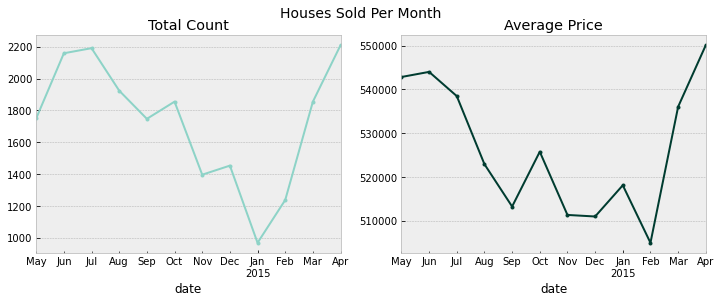

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

monthly_count['price'].plot(title='Total Count', ax=axes[0], colormap='Set3', marker='.')
monthly_avg['price'].plot(title='Average Price', ax=axes[1], colormap='BrBG_r', marker='.')

axes[0].grid(axis='x', linewidth=0)
axes[1].grid(axis='x', linewidth=0)

plt.suptitle('Houses Sold Per Month', fontsize=14)

plt.savefig('data/images/fig2.png', dpi=200, transparent=True) 
plt.show()

The highest peaks in the number of houses sold per month happened in the seasons of spring and summer. The decline in the months that followed dropped to the lowest point at the first month of the new year. As for the price of houses sold per month, the values followed roughly the same pattern.

***
Check for multicollinearity:

In [19]:
def check_correlation(data, threshold):
    '''Checks for the highest correlated features in a dataframe given a threshold'''
    df = data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    
    df['pairs'] = list(zip(df['level_0'], df['level_1']))
    df = df.set_index(['pairs']).drop(columns=['level_1', 'level_0'])
    
    df.columns = ['correlation']
    
    df = df.drop_duplicates()
    df = df[(df['correlation'] > threshold) & (df['correlation'] < 1)]
    
    return df

In [20]:
check_correlation(data, 0.75)

,correlation
pairs,
"(yr_renovated, renovated)",0.999968
"(age, yr_built)",0.999873
"(sqft_living, sqft_above)",0.869907
"(basement, sqft_basement)",0.826651
"(sqft_living15, sqft_living)",0.753874
"(sqft_living, grade)",0.751196


In [21]:
# Drop highly collinear features and useless feature like id
to_drop = ['id', 'date', 'yr_renovated', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

data = data.drop(columns=to_drop)

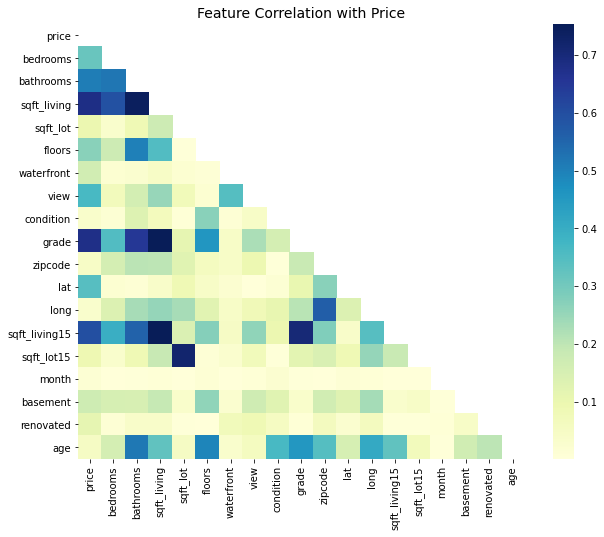

In [22]:
plt.figure(figsize=(10,8))
plt.style.use('default')

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr.abs(), mask=mask, cmap='YlGnBu')

plt.title('Feature Correlation with Price', fontsize=14)

plt.savefig('data/images/fig3.png', dpi=200, transparent=True)
plt.show()

Price is strongly correlated with `sqft_living`, `grade`, `sqft_living15`, `bathrooms`, and `bathrooms`. 

Let's visualize their relationships and distributions.

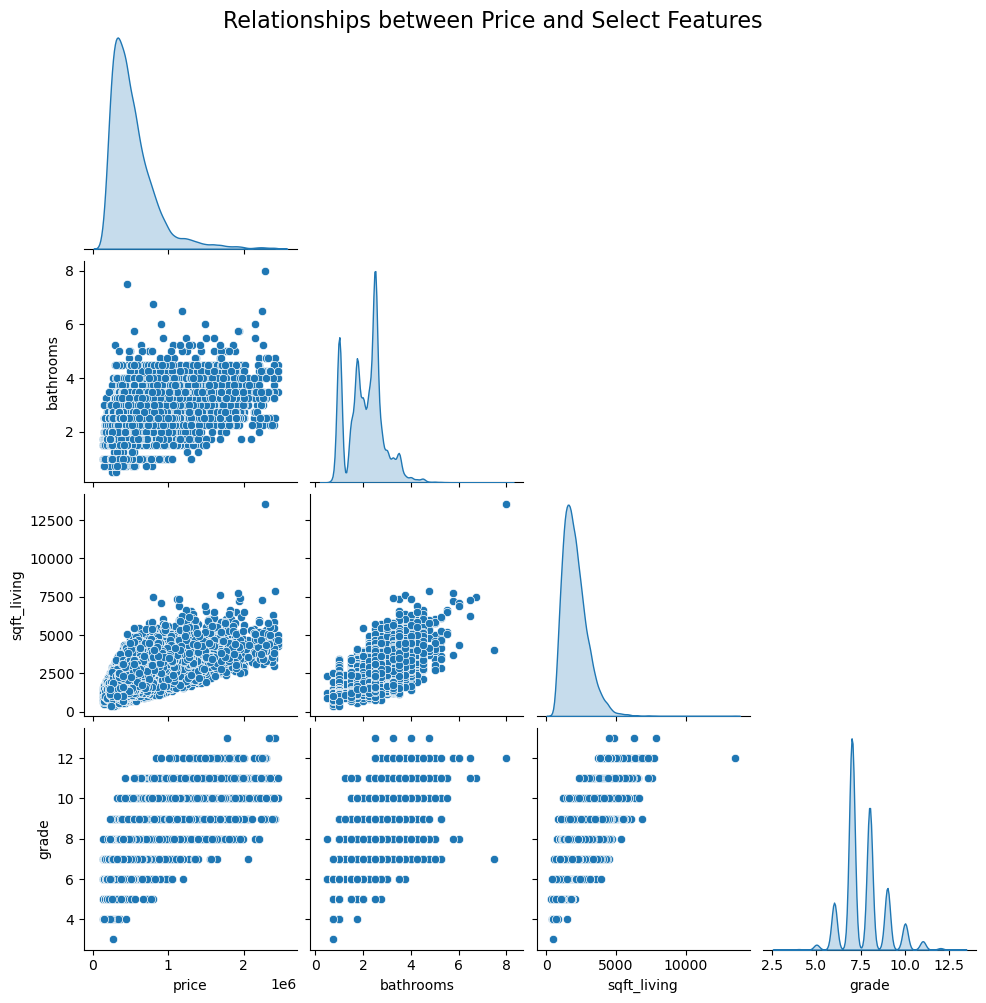

In [23]:
select_features = ['price', 'bathrooms', 'sqft_living', 'grade']
sns.pairplot(data, vars=select_features, diag_kind='kde', corner=True).fig.suptitle('Relationships between Price and Select Features', 
                                                                                    fontsize=16, y=1)
plt.savefig('data/images/fig4.png', dpi=200, transparent=True)
plt.show()

### 3.2 Geospatial Mapping

> '*Location, location, location*'

**Location is important in real estate and in analysis!**

Let's map the data points.

In [24]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

def map_data(data_, title, name, colormap):
    '''Plots the data points using latitude and longitude on top of King County map'''
    plt.style.use('seaborn')
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    king_county_fig = gpd.read_file('data/map/Incorporated_Areas_of_King_County___city_area.shp')
    
    geometry = [Point(xy) for xy in zip(data_['long'], data_['lat'])]
    geo_data = gpd.GeoDataFrame(data_, crs='EPSG:4326', geometry=geometry)
    
    king_county_fig.plot(ax=ax, alpha=0.4, color='grey')
    geo_data.plot(column='price', ax=ax, alpha=0.4, legend=True, markersize=8, cmap=plt.get_cmap(colormap), legend_kwds={'shrink': 0.7, 'format': '%.0f'})
    
    plt.xlim(data['long'].min(), data['long'].max())
    plt.ylim(data['lat'].min(), data['lat'].max())
    plt.ticklabel_format(style='plain')
    
    plt.title(title, fontsize=14)
    
    plt.savefig(f'data/images/{name}.png', dpi=200, transparent=True)
    plt.show()

In [25]:
# Create dataframe of houses sold under a million dollars
UnderMillion = data.loc[(data['price'] < 1000000)]

# Create dataframe of houses sold over a million dollars
OverMillion = data.loc[(data['price'] >= 1000000)]

In [26]:
# Store dataframe for retrieval in map notebook
%store UnderMillion 

Stored 'UnderMillion' (DataFrame)


In [27]:
# Store dataframe for retrieval in map notebook
%store OverMillion

Stored 'OverMillion' (DataFrame)


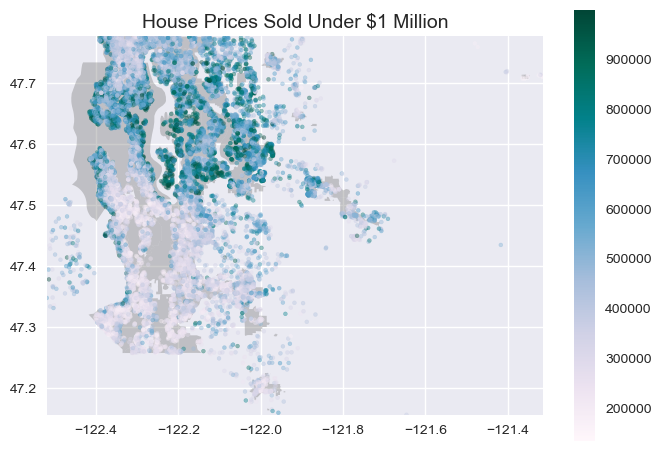

In [28]:
map_data(UnderMillion, 'House Prices Sold Under $1 Million', 'fig5', 'PuBuGn')

The concentrated geographic patterns reveal parts of the county populated by the more expensive houses represented by darker colors like the island at the center. The even more expensive houses sold for over a million dollars are located at about the same spots as the dark dots. 

Locate the highest priced houses in the data in the following map:

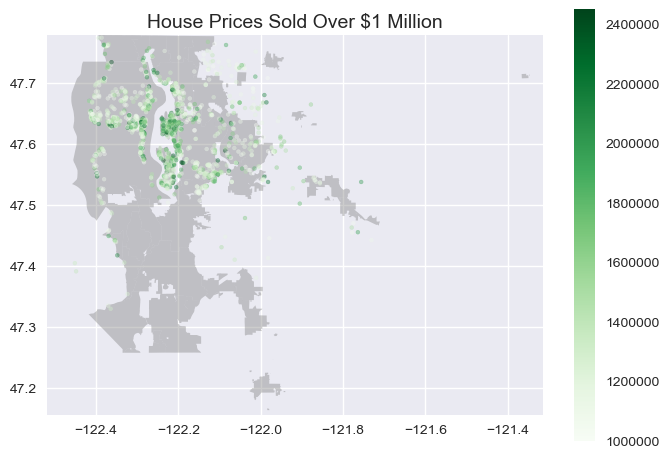

In [29]:
map_data(OverMillion, 'House Prices Sold Over $1 Million', 'fig6', 'Greens')

***
**Interactive Map**

I created choropleth maps ([map notebook](https://github.com/czarinagluna/regression-analysis-for-estimating-prices/blob/main/map.ipynb)) to further understand how house prices vary by location.

To interact with the maps, please use the [notebook viewer](https://nbviewer.org/github/czarinagluna/regression-analysis-for-estimating-prices/blob/main/map.ipynb).

![](data/images/fig7.png)

### 3.3 Feature Engineering

King County Population:

In [30]:
# Import data from population census
population = pd.read_csv('data/population.csv')

population_density = population.loc[:, ['City Name', 'Total Population 2010', 'Population Density (Persons / Square Mile) 2010']]
population_density = population_density.rename(columns={'City Name':'city', 'Total Population 2010':'population', 'Population Density (Persons / Square Mile) 2010':'pop_density'})

In [31]:
king_county_cities = ['Algona', 'Auburn', 'Beaux Arts Village', 'Bellevue', 'Black Diamond', 
                      'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 'Covington', 
                      'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 'Hunts Point', 
                      'Issaquah', 'Kenmore', 'Kent', 'Kirkland', 'Lake Forest Park', 
                      'Maple Valley', 'Medina', 'Mercer Island', 'Milton', 'Newcastle', 
                      'Normandy Park', 'North Bend', 'Pacific', 'Redmond', 'Renton', 
                      'Sammamish', 'SeaTac', 'Seattle', 'Shoreline', 'Skykomish', 
                      'Snoqualmie', 'Tukwila', 'Woodinville', 'Yarrow Point']

city_names = pd.DataFrame(king_county_cities, columns=['city'])

In [32]:
import warnings
warnings.filterwarnings('ignore')

king_county_population = pd.merge(population_density, city_names, on=['city'])
king_county_population = king_county_population.append({'city':'Vashon','population':10624, 'pop_density':287.22}, ignore_index=True)

In [33]:
zipcodes = pd.read_csv('data/zipcodes.csv')

zipcodes['city'] = zipcodes['zipcode'].apply(lambda x: x.split('(')[1].strip('()'))
zipcodes['zipcode'] = zipcodes['zipcode'].apply(lambda x: int(x.split()[0]))

In [34]:
# Map population data to cities
king_county_zipcode = pd.merge(king_county_population, zipcodes, on=['city'])

engineered_data = pd.merge(data, king_county_zipcode, how='inner', on=['zipcode'])

Distance to Seattle and Redmond:

In [35]:
from haversine import haversine, Unit

def find_distance(center, lat, long):
    '''Uses haversine function to find distance between a given center and a point's latitude and longitude'''
    house = (lat, long)
    distance = haversine(center, house, unit=Unit.MILES)
    return distance

def add_distance(data):
    '''Applies the find_distance function to dataframe to add columns for distances to Seattle and Redmond'''
    seattle = (47.608013, -122.335167)
    redmond = (47.673988, -122.121513)
    
    data['to_seattle'] = data.apply(lambda x: find_distance(seattle, x['lat'], x['long']), axis=1)
    data['to_redmond'] = data.apply(lambda x: find_distance(redmond, x['lat'], x['long']), axis=1)
    data['distance'] = data['to_seattle'] + data['to_redmond']

    data = data.drop(columns=['lat', 'long'])
    return data

In [36]:
engineered_data = add_distance(engineered_data)

## IV. Data Modeling

**Train Test Split**

In [37]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['price'])
y = data['price']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=112221)

Baseline Model:

In [38]:
# Simple linear regression using one independent variable
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_tr[['sqft_living']], y_tr)

baseline_pred = lr_model.predict(X_te[['sqft_living']])

In [39]:
# Evaluate using R squared and RMSE scores
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

baseline_cross_val = cross_val_score(lr_model, X_tr[['sqft_living']], y_tr, scoring='neg_root_mean_squared_error', cv=10)
baseline_cross_val_mean = -(baseline_cross_val.mean())

baseline_rmse = mean_squared_error(y_te, baseline_pred, squared=False)
baseline_score = lr_model.score(X_te[['sqft_living']], y_te)

In [40]:
metric_table = pd.DataFrame(columns = ['model', 'cv_rmse', 'test_rmse', 'test_score'])
metric_table = metric_table.append({'model': 'simple_lr', 
                                    'cv_rmse': f'{baseline_cross_val_mean:.2f}', 
                                    'test_rmse': f'{baseline_rmse:.2f}', 
                                    'test_score': f'{baseline_score:.2f}'}, ignore_index=True)

In [41]:
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47


### 4.1 Linear Regression

Multiple Linear Regression:

In [42]:
def run_model(regressor, name, X_train=X_tr, X_test=X_te, y_train=y_tr, y_test=y_te):
    '''Fits a regression model on train set, predicts on the test set, and returns cross validation and test scores'''
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    cross_val = cross_val_score(regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
    cross_val_mean = -(cross_val.mean())
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    score = regressor.score(X_test, y_test)
    
    return metric_table.append({'model': name, 
                                'cv_rmse': f'{cross_val_mean:.2f}', 
                                'test_rmse': f'{rmse:.2f}', 
                                'test_score': f'{score:.2f}'}, ignore_index=True)

In [43]:
# Use multiple numerical features
num_feat = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_living15', 'sqft_lot15', 'age']

metric_table = run_model(lr_model, 'multiple_lr', X_tr[num_feat], X_te[num_feat])
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56


Standardization:

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_sc_tr = pd.DataFrame(scaler.fit_transform(X_tr[num_feat], y_tr), columns=X_tr[num_feat].columns, index=X_tr[num_feat].index)
X_sc_te = pd.DataFrame(scaler.transform(X_te[num_feat]), columns=X_te[num_feat].columns, index=X_te[num_feat].index)

metric_table = run_model(lr_model, 'standardized_lr', X_sc_tr, X_sc_te)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56


In [45]:
# Data with engineered features such as population and distance
X_ = engineered_data.drop(columns=['price'])
y_ = engineered_data['price']

X_train, X_test, y_train, y_test = train_test_split(X_, y_, random_state=112221)

In [46]:
# Store for retrieval in grid search notebook
%store X_train 

Stored 'X_train' (DataFrame)


In [47]:
# Store for retrieval in grid search notebook
%store y_train 

Stored 'y_train' (Series)


In [48]:
num_feat.extend(['population', 'pop_density', 'to_seattle', 'to_redmond', 'distance'])

X_scaled_train = pd.DataFrame(scaler.fit_transform(X_train[num_feat], y_train), columns=X_train[num_feat].columns, index=X_train[num_feat].index)
X_scaled_test = pd.DataFrame(scaler.transform(X_test[num_feat]), columns=X_test[num_feat].columns, index=X_test[num_feat].index)

metric_table = run_model(lr_model, 'feature_lr', X_scaled_train, X_scaled_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68


Machine Learning Pipeline:

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_pipe = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Perform one hot encoding on categorical features
cat_pipe = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [50]:
from sklearn.compose import ColumnTransformer

num_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_living15', 'sqft_lot15', 
                'age', 'population', 'pop_density', 'to_seattle', 'to_redmond', 'distance']
cat_features = ['waterfront', 'view', 'condition', 'grade', 'zipcode', 'month', 'basement', 'renovated', 'city']

col_transformer = ColumnTransformer([
    ('num_transformer', num_pipe, num_features),
    ('cat_transformer', cat_pipe, cat_features)
])

In [51]:
# Multiple linear regression using all features
lr_pipe = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('lr', LinearRegression())
])

metric_table = run_model(lr_pipe, 'pipeline_lr', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85


Ridge and Lasso Regression:

In [52]:
from sklearn.linear_model import Ridge

ridge_pipe = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('ridge', Ridge())
])

metric_table = run_model(ridge_pipe, 'ridge_lr', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85


In [53]:
from sklearn.linear_model import Lasso

lasso_pipe = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('lasso', Lasso(max_iter=2000))
])

metric_table = run_model(lasso_pipe, 'lasso_lr', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85


Polynomial Regression:

In [54]:
from sklearn.preprocessing import PolynomialFeatures

poly_col_transformer = ColumnTransformer([
    ('num_transformer', num_pipe, num_features),
    ('polynomial', PolynomialFeatures(2), num_features),
    ('cat_transformer', cat_pipe, cat_features),
])

poly_pipe = Pipeline(steps=[
    ('poly_col_transformer', poly_col_transformer),
    ('lr', LinearRegression())
])

metric_table = run_model(poly_pipe, 'poly_lr', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87


### 4.2 Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor

dt_pipe = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('decision_tree', DecisionTreeRegressor())
])

metric_table = run_model(dt_pipe, 'default_dt', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87
8,default_dt,165174.85,162057.54,0.72


In [56]:
# Store for retrieval in grid search notebook
%store dt_pipe

Stored 'dt_pipe' (Pipeline)


In [57]:
poly_dt = Pipeline(steps=[
    ('poly_col_transformer', poly_col_transformer),
    ('decision_tree', DecisionTreeRegressor())
])

metric_table = run_model(poly_dt, 'poly_dt', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87
8,default_dt,165174.85,162057.54,0.72
9,poly_dt,170853.84,163749.93,0.71


Grid search ([notebook](https://github.com/czarinagluna/regression-analysis-for-estimating-prices/blob/main/gridsearch.ipynb)) is performed to find the optimal parameters of the Decision Tree model.

In [58]:
tuned_dt = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('decision_tree', DecisionTreeRegressor(criterion='friedman_mse', max_depth=None, min_samples_leaf=5, min_samples_split=45))
])

metric_table = run_model(tuned_dt, 'tuned_dt', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87
8,default_dt,165174.85,162057.54,0.72
9,poly_dt,170853.84,163749.93,0.71


In [59]:
poly_tuned_dt = Pipeline(steps=[
    ('poly_col_transformer', poly_col_transformer),
    ('decision_tree', DecisionTreeRegressor(criterion='friedman_mse', max_depth=None, min_samples_leaf=5, min_samples_split=45))
])

metric_table = run_model(poly_tuned_dt, 'poly_tuned_dt', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87
8,default_dt,165174.85,162057.54,0.72
9,poly_dt,170853.84,163749.93,0.71


### 4.3 Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('random_forest', RandomForestRegressor())
])

metric_table = run_model(rf_pipe, 'default_rf', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87
8,default_dt,165174.85,162057.54,0.72
9,poly_dt,170853.84,163749.93,0.71


In [61]:
# Store for retrieval in grid search notebook
%store rf_pipe

Stored 'rf_pipe' (Pipeline)


Grid search ([notebook](https://github.com/czarinagluna/regression-analysis-for-estimating-prices/blob/main/gridsearch.ipynb)) is performed to find the optimal parameters of the Random Forest model.

In [62]:
tuned_rf = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('random_forest', RandomForestRegressor(criterion='friedman_mse', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150))
])

metric_table = run_model(tuned_rf, 'tuned_rf', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87
8,default_dt,165174.85,162057.54,0.72
9,poly_dt,170853.84,163749.93,0.71


In [63]:
poly_tuned_rf = Pipeline(steps=[
    ('poly_col_transformer', poly_col_transformer),
    ('random_forest', RandomForestRegressor(criterion='friedman_mse', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150))
])

metric_table = run_model(poly_tuned_rf, 'poly_tuned_rf', X_train, X_test, y_train, y_test)
metric_table

,model,cv_rmse,test_rmse,test_score
0,simple_lr,227585.85,217065.62,0.47
1,multiple_lr,206288.15,198811.78,0.56
2,standardized_lr,206288.15,198811.78,0.56
3,feature_lr,177887.09,173055.45,0.68
4,pipeline_lr,124231.74,119145.65,0.85
5,ridge_lr,124635.57,119894.29,0.85
6,lasso_lr,124231.29,119121.01,0.85
7,poly_lr,112687.15,110277.17,0.87
8,default_dt,165174.85,162057.54,0.72
9,poly_dt,170853.84,163749.93,0.71


In [64]:
# The best model with the best estimate 
bestimate_model = tuned_rf
bestimate_model.fit(X_train, y_train)
bestimate_pred = bestimate_model.predict(X_test)

## V. Results

Model Performance:

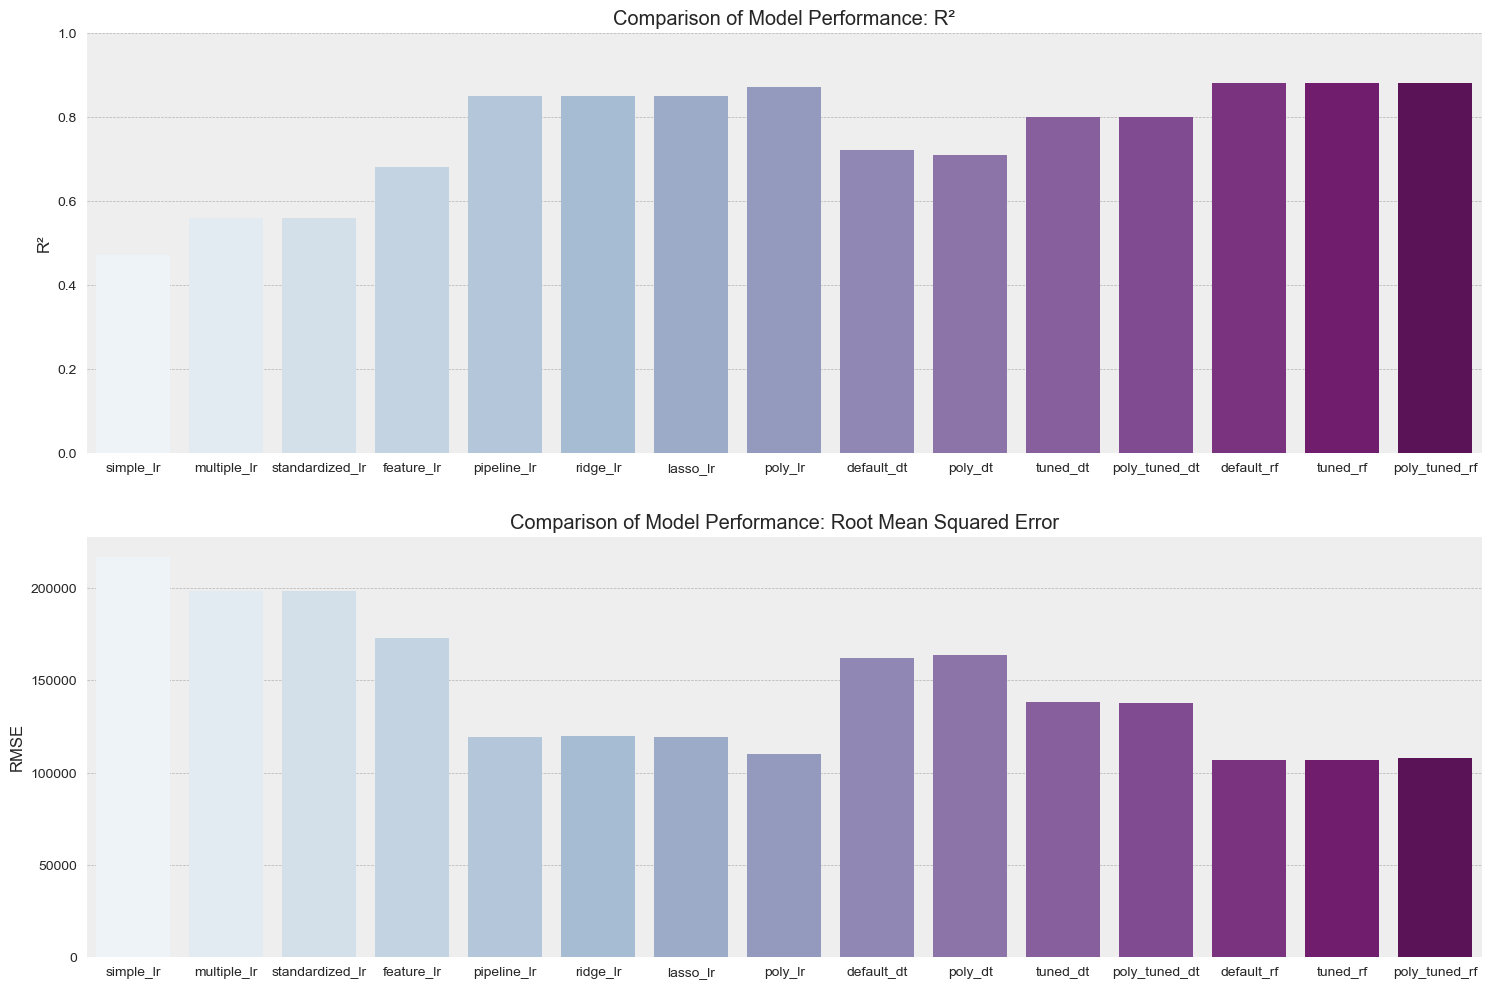

In [65]:
# Visualize the metrics evaluated per model
metric_table[['cv_rmse', 'test_rmse', 'test_score']] = metric_table[['cv_rmse', 'test_rmse', 'test_score']].astype('float')

plt.style.use('bmh')
fig, axes = plt.subplots(nrows=2, figsize=(18,12))

# First metric is the R-squared score
sns.barplot(x='model', y='test_score', data=metric_table, palette='BuPu', ax=axes[0], zorder=99)
axes[0].set_xlabel('')
axes[0].set_ylabel('R²')
axes[0].set_ylim(0, 1)
axes[0].set_title('Comparison of Model Performance: R²')

# Second metric is the root mean squared error
sns.barplot(x='model', y='test_rmse', data=metric_table, palette='BuPu', ax=axes[1], zorder=99)
axes[1].set_xlabel('')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Comparison of Model Performance: Root Mean Squared Error')

plt.savefig('data/images/fig8.png', dpi=200, transparent=True) 
plt.show()

**Baseline to *Bestimate* Model**

The baseline model `simple_lr` significantly improved to the `tuned_rf`, our *bestimate* model:
* from an R-squared of 0.47 to 0.88, and
* from a Root Mean Squared Error of USD 217,000 to USD  107,000

To visualize the significant difference, let's plot how far away the predictions of the baseline model are to the actual prices versus how much closer the predictions of the bestimate model are:

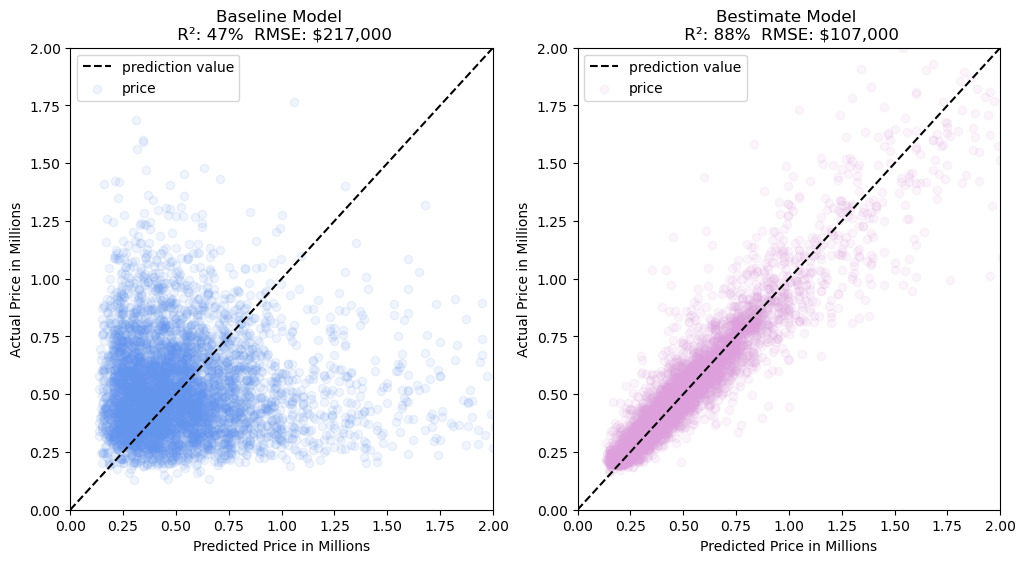

In [66]:
plt.style.use('default')
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

# Perfect line where the predicted price is equal to the actual price
perfect_line = np.arange(0, 3)

# Baseline simple linear regression model
axes[0].plot(perfect_line, linestyle='--', color='black', label='prediction value')
axes[0].scatter(y_test/1000000, baseline_pred/1000000, alpha=0.1, color='cornflowerblue', label='price')
axes[0].set_xlabel('Predicted Price in Millions')
axes[0].set_ylabel('Actual Price in Millions')
axes[0].set_title('Baseline Model \n R²: 47%  RMSE: $217,000')
axes[0].set_xlim(0, 2)
axes[0].set_ylim(0, 2)
axes[0].legend()

# Bestimate random forest model
axes[1].plot(perfect_line, linestyle='--', color='black', label='prediction value')
axes[1].scatter(y_test/1000000, bestimate_pred/1000000, alpha=0.1, color='plum', label='price')
axes[1].set_xlabel('Predicted Price in Millions')
axes[1].set_ylabel('Actual Price in Millions')
axes[1].set_title('Bestimate Model \n R²: 88%  RMSE: $107,000')
axes[1].set_xlim(0, 2)
axes[1].set_ylim(0, 2)
axes[1].legend()

plt.savefig('data/images/fig9.png', dpi=200, transparent=True) 
plt.show()

Important features under the *bestimate* model:

In [67]:
from sklearn.inspection import permutation_importance
result = permutation_importance(bestimate_model, X_test, y_test, n_repeats=10, random_state=112221, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

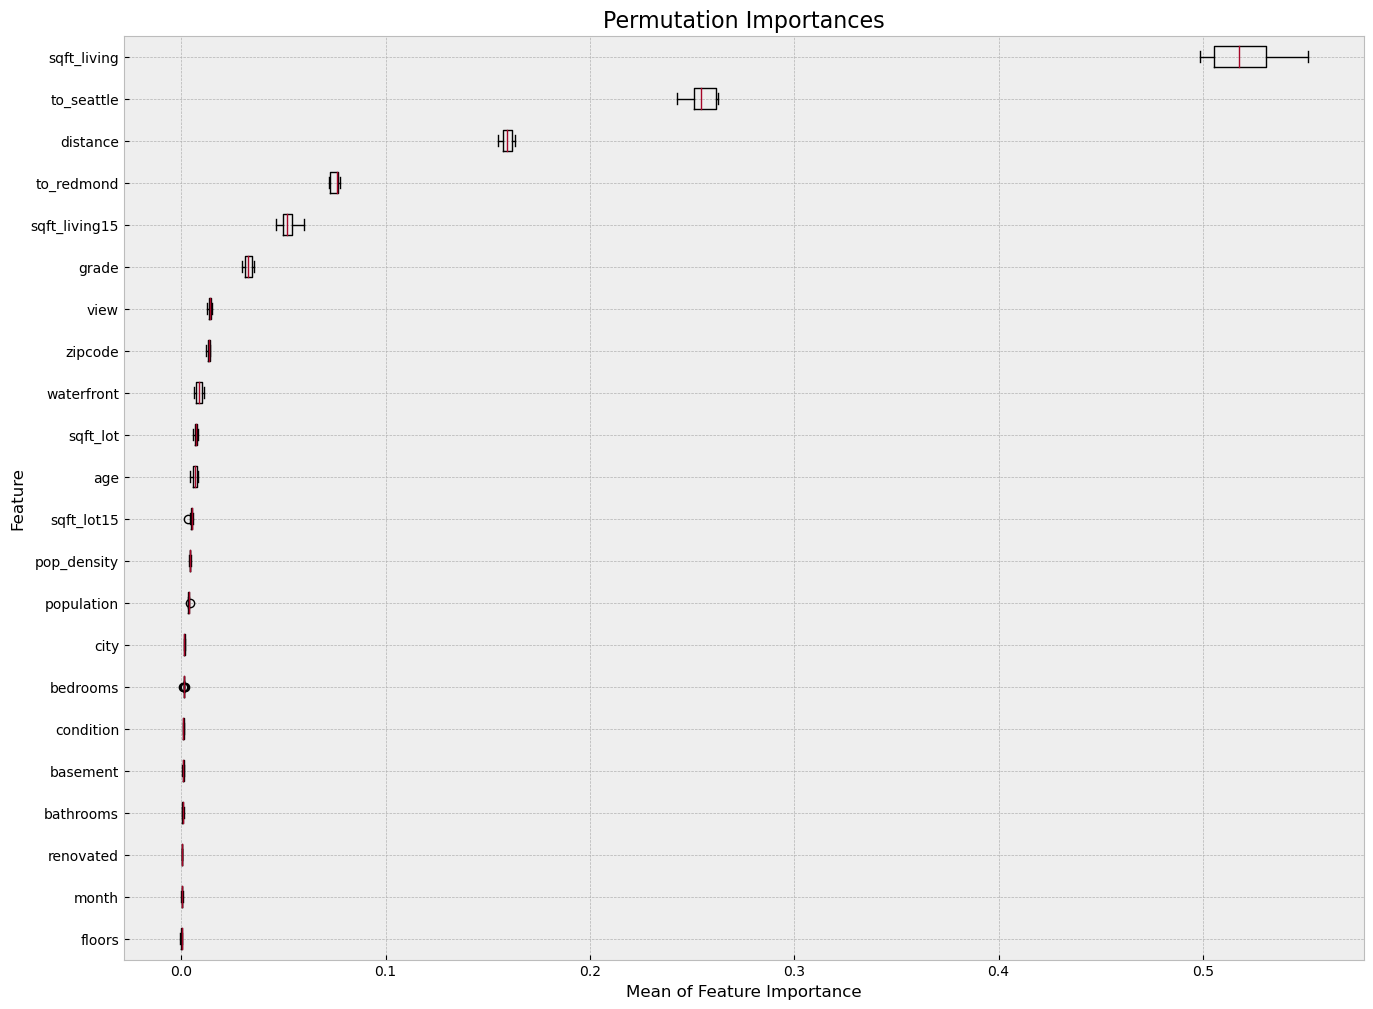

In [68]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(16,12))

ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx], )
ax.set_title('Permutation Importances', fontsize=16)
ax.set_xlabel('Mean of Feature Importance')
ax.set_ylabel('Feature')

plt.savefig('data/images/fig10.png', dpi=200, transparent=True) 
plt.show()

For advisory, the top five features with the highest mean feature importances to the model are:
1. Square footage of living space
2. Distance to Seattle
3. Total distance to both Seattle and Redmond
4. Distance to Redmond
5. Square footage of living space of the nearest 15 neighbors

The other important features that follows are overall grade related to the construction and design of the house, quality of view from the house, zipcode, whether the house is on a waterfront, and square footage of lot.
***
**Model Deployment**

Finally, I deploy the Random Forest regression model ([demo](https://streamlit.io/)) as a prototype I develop for a client-facing application that serves as a Home Value Estimator.

## VI. Further Research

For further research, the data should be updated to more recent transactions in King County, and more features should be added such as more information on comparable and neighboring houses.

# Contact

Feel free to contact me for any questions and connect with me on [Linkedin](https://www.linkedin.com/in/czarinagluna/).